# Create the Environment

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM, Embedding
import matplotlib.pyplot as plt
import os

# Download Text Data

In [ ]:
file_URL = "https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt"
file_name= "shakespeare.txt"

path = keras.utils.get_file(file_name, file_URL)

1115394/1115394 [==============================] - 0s 0us/step


In [ ]:
raw = open(path, 'rb').read()
print(raw[250:400])

b"\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us kill him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it "


In [ ]:
text = raw.decode(encoding='utf-8')
print(text[250:400])


All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it 


In [ ]:
len(text)

1115394

# Vectorize Word Characters into Integers

In [ ]:
vocabulary = np.array(sorted(set(text)))
len(vocabulary)

65

In [ ]:
tokenizer = {char:i for i,char in enumerate(vocabulary)}

In [ ]:
for i in range(20):
    char = vocabulary[i]
    token = tokenizer[char]
    print('%4s : %4d'%(repr(char),token))

'\n' :    0
 ' ' :    1
 '!' :    2
 '$' :    3
 '&' :    4
 "'" :    5
 ',' :    6
 '-' :    7
 '.' :    8
 '3' :    9
 ':' :   10
 ';' :   11
 '?' :   12
 'A' :   13
 'B' :   14
 'C' :   15
 'D' :   16
 'E' :   17
 'F' :   18
 'G' :   19


In [ ]:
vector = np.array([tokenizer[char] for char in text])

print('\nSample Text \n')
print('-'*70)
print(text[:100])
print('-'*70)
print('\n\nCorresponding Integer Vector \n')
print('-'*70)
print(vector[:100])
print('-'*70)



Sample Text 

----------------------------------------------------------------------
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You
----------------------------------------------------------------------


Corresponding Integer Vector 

----------------------------------------------------------------------
[18 47 56 57 58  1 15 47 58 47 64 43 52 10  0 14 43 44 53 56 43  1 61 43
  1 54 56 53 41 43 43 42  1 39 52 63  1 44 59 56 58 46 43 56  6  1 46 43
 39 56  1 51 43  1 57 54 43 39 49  8  0  0 13 50 50 10  0 31 54 43 39 49
  6  1 57 54 43 39 49  8  0  0 18 47 56 57 58  1 15 47 58 47 64 43 52 10
  0 37 53 59]
----------------------------------------------------------------------


In [ ]:
vector = tf.data.Dataset.from_tensor_slices(vector)

sequences = vector.batch(100, drop_remainder=True)

In [ ]:
def prepare_dataset(seq):
    input_vector = seq[:-1]
    target_vector = seq[1:]
    return input_vector, target_vector

dataset = sequences.map(prepare_dataset)

In [ ]:
for inp, tar in dataset.take(1):
    print(inp.numpy())
    print(tar.numpy())
    inp_text = ''.join(vocabulary[inp])
    tar_text = ''.join(vocabulary[tar])
    print(repr(inp_text))
    print(repr(tar_text))

[18 47 56 57 58  1 15 47 58 47 64 43 52 10  0 14 43 44 53 56 43  1 61 43
  1 54 56 53 41 43 43 42  1 39 52 63  1 44 59 56 58 46 43 56  6  1 46 43
 39 56  1 51 43  1 57 54 43 39 49  8  0  0 13 50 50 10  0 31 54 43 39 49
  6  1 57 54 43 39 49  8  0  0 18 47 56 57 58  1 15 47 58 47 64 43 52 10
  0 37 53]
[47 56 57 58  1 15 47 58 47 64 43 52 10  0 14 43 44 53 56 43  1 61 43  1
 54 56 53 41 43 43 42  1 39 52 63  1 44 59 56 58 46 43 56  6  1 46 43 39
 56  1 51 43  1 57 54 43 39 49  8  0  0 13 50 50 10  0 31 54 43 39 49  6
  1 57 54 43 39 49  8  0  0 18 47 56 57 58  1 15 47 58 47 64 43 52 10  0
 37 53 59]
'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYo'
'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'


# Batch and Prefetch Dataset

In [ ]:
len(sequences)//64

174

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

data = dataset.batch(64, drop_remainder=True).repeat()
data = data.prefetch(AUTOTUNE)

STEPS_PER_EPOCH = len(sequences)//64

In [ ]:
for inp, tar in data.take(1):
    print(inp.numpy().shape)
    print(tar.numpy().shape)

(64, 99)
(64, 99)


# Build Model

In [ ]:
model = keras.Sequential([

    Embedding(len(vocabulary), 64, batch_input_shape=[64,None]),

    LSTM(512, return_sequences=True, stateful=True),
    LSTM(512, return_sequences=True, stateful=True),

    Dense(len(vocabulary))
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (64, None, 64)            4160      
                                                                 
 lstm (LSTM)                 (64, None, 512)           1181696   
                                                                 
 lstm_1 (LSTM)               (64, None, 512)           2099200   
                                                                 
 dense (Dense)               (64, None, 65)            33345     
                                                                 
Total params: 3318401 (12.66 MB)
Trainable params: 3318401 (12.66 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


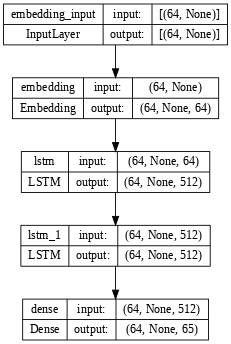

In [ ]:
keras.utils.plot_model(model, show_shapes=True, dpi=64)

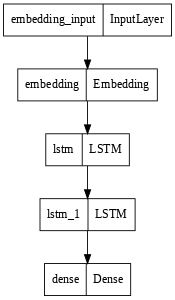

In [ ]:
keras.utils.plot_model(model, show_shapes=False, dpi=64)

# Train the Model

In [ ]:
for example_inp, example_tar in data.take(1):
    example_pred = model(example_inp)
    print(example_tar.numpy().shape)
    print(example_pred.shape)


(64, 99)
(64, 99, 65)


In [ ]:
ids = tf.random.categorical(example_pred[0], num_samples=1)
ids.shape

TensorShape([99, 1])

In [ ]:
ids[0][-1].numpy()

35

In [ ]:
checkpoint_path = os.path.join("./checkpoints", "ckpt_{epoch}")
checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True)

In [ ]:
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True))

history = model.fit(data,
                    epochs=2,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    callbacks=[checkpoint_callback])

Epoch 1/2
174/174 [==============================] - 910s 5s/step - loss: 3.0077
Epoch 2/2
174/174 [==============================] - 913s 5s/step - loss: 2.2364


# Performance Evaluation

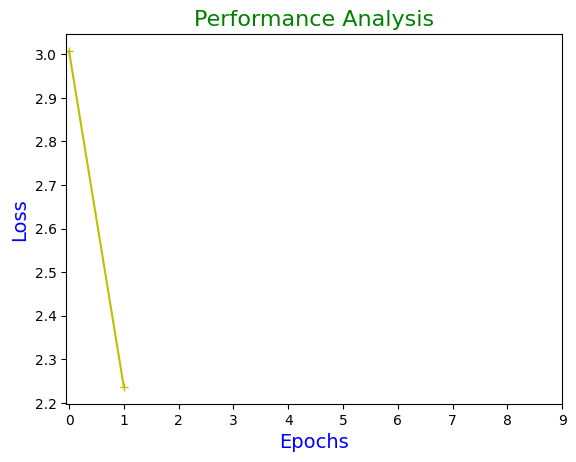

In [ ]:
plt.plot(history.history['loss'], '+-y')
plt.title('Performance Analysis', size=16, color='green')
plt.xlabel('Epochs', size=14, color='blue')
plt.ylabel('Loss', size=14, color='blue')
plt.xticks(range(10))
plt.show()

# Inference - Next Character Prediction

In [ ]:
model.reset_states()

In [ ]:
sample = 'ANTHONIO:'

sample_vector = [tokenizer[s] for s in sample]
predicted = sample_vector

sample_tensor = tf.expand_dims(sample_vector, 0)

sample_tensor = tf.repeat(sample_tensor, 64, axis=0)

temperature = 0.6
for i in range(1000):
    pred = model(sample_tensor)

    pred = pred[0].numpy()/temperature
    pred = tf.random.categorical(pred, num_samples=1)[-1,0].numpy()
    predicted.append(pred)
    sample_tensor = predicted[-99:]
    sample_tensor = tf.expand_dims([pred],0)

    sample_tensor = tf.repeat(sample_tensor, 64, axis=0)



In [ ]:
pred_char = [vocabulary[i] for i in predicted]
generated = ''.join(pred_char)
print(generated)

ANTHONIO::
So best thene the come.

MRINCENSIO:
Get that in bestrening the mister herter nit abering.

PRTRUCHIO:
E hast bese thou ghand and kiken srolean thall come growe
The toot the sounte the paring of the porster the and sirest,
Tour mest the crian a sunces he purines!

PRAPSIO:
O the matt to thit the door heer and doure,
I have fare in hing thath ard this to beavenes.

PERTIO:
What have the pronn is hores it betand the sertange.

DRREMEO:
Of hith with he best that our best it the gain,
What that hen heve and truess, to appieting comnt.

TETRANON:
O mim, that I hear thing mustnd pakes menons on the rownt and of thee shall the lore;
And singer harn thich will wath sould sones
There he is her you;

BAPTARRO:
What thik this have mans so beated be fore and and beaning to be the hoves one tele sire.

PETRTIS:
Whe come so buile that some
And shange chat hos hour-s the hings to the gariong vith do gring of hath his mesten wit epaig is best ome thou spunce to have are.

PETRANO:
What reak

### vary temperature to see yet different prediction

In [ ]:
sample = 'ANTHONIO:'

sample_vector = [tokenizer[s] for s in sample]
predicted = sample_vector

sample_tensor = tf.expand_dims(sample_vector, 0)

sample_tensor = tf.repeat(sample_tensor, 64, axis=0)


temperature = 0.8
for i in range(1000):
    pred = model(sample_tensor)

    pred = pred[0].numpy()/temperature
    pred = tf.random.categorical(pred, num_samples=1)[-1,0].numpy()
    predicted.append(pred)
    sample_tensor = predicted[-99:]
    sample_tensor = tf.expand_dims([pred],0)

    sample_tensor = tf.repeat(sample_tensor, 64, axis=0)



In [ ]:
pred_char = [vocabulary[i] for i in predicted]
generated = ''.join(pred_char)
print(generated)

ANTHONIO:
Thase hingtio,
U hime it is'lonchase offisher with! not is e gume pusen? Siem in the bradk, sore tall of thut uragtiixing op
tither ment;
And ow thae.

CERRSINTIO:
Whas is to Iat the eave:
That hish the fore houn ar thy be wratplo:
Fed the wake be inow theme.

TRUCIO:
Ware a an musthanes arentse.

LUCPIO:
That mighed thou srever thee
Ofall me frime and goll chookes tcull!

LURTAND IO:
Whe conns shou not beath, and whee of wirlinn fint of thy that or as thes tust catkor thit sorntor. how e will frotthe and apit where priened couns these
Anceisest hame thee mestend and nier hearh
UNTove, this o grich,, so,
What share mith the keen Kot aresen, and wincher, but thime
And somed, to that radiouse fraed?

SEORNECVe:
And ino, sponns in moster wo have pistersases.

PARTIO:
Hot the suve hath the-changt kither af thou bister:
Now, mirging wertingion this what,
Theroes arier under-dwy hon the vasente deald
Not epearten parisent,

GRESHA:
In, and anow ot if ' hare.

BRARPRO:
And coms thou